In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


# Data

In [48]:
data = pd.read_csv('bio_train.csv', header=None)  # Ensure the file name and path are correct
filtered_data = data.groupby(0).apply(lambda x: x.head(40)).reset_index(drop=True)

# Now 'filtered_data' contains 10 entries for each BLOCK ID
X = filtered_data.iloc[:, 3:].values  # Feature columns
true_labels = filtered_data.iloc[:, 0].values  # True labels (BLOCK ID)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Lloyd’s algorithm for k-Means Clustering 

In [51]:
# Custom K-means and related functions
def initialize_centroids(X, k):
    """Randomly initialize centroids from the data points X."""
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    """Assign data points to the nearest centroid using batch processing."""
    n_samples = X.shape[0]
    batch_size = 100  # Adjust batch size based on available memory
    labels = np.empty(n_samples, dtype=int)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        distances = np.sqrt(((X[start_idx:end_idx] - centroids[:, np.newaxis])**2).sum(axis=2))
        labels[start_idx:end_idx] = np.argmin(distances, axis=0)
    
    return labels


def update_centroids(X, labels, k):
    """Update centroids as the mean of assigned data points."""
    new_centroids = np.empty((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(axis=0)
        else:
            # If cluster has no assigned points, randomly reinitialize the centroid
            new_centroids[i] = X[np.random.choice(X.shape[0])]
    return new_centroids


def kmeans(X, k, max_iters=5000):
    centroids = initialize_centroids(X, k)
    inertia_history = []
    total_distance_calculations = 0
    start_time = time.time()  # Start timing

    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        total_distance_calculations += X.shape[0] * k  # Each assign_clusters call
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time  # End timing
    return centroids, labels, i + 1, inertia_history, total_distance_calculations, runtime

In [52]:
k = 153
max_iters = 1000

# Lists to store results
all_labels = []
all_centroids = []
all_nmi_scores = []
all_runtimes = []
all_distance_calculations = []
all_inertia_histories = []

# Perform clustering five times
for i in range(5):
    centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans(X_scaled, k, max_iters)
    nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
    
    # Append results to lists
    all_labels.append(labels)
    all_centroids.append(centroids)
    all_nmi_scores.append(nmi_score)
    all_runtimes.append(runtime)
    all_distance_calculations.append(distance_calculations)
    all_inertia_histories.append(inertia_history)

K-means Iteration:   4%|▍         | 39/1000 [00:16<06:49,  2.35it/s]


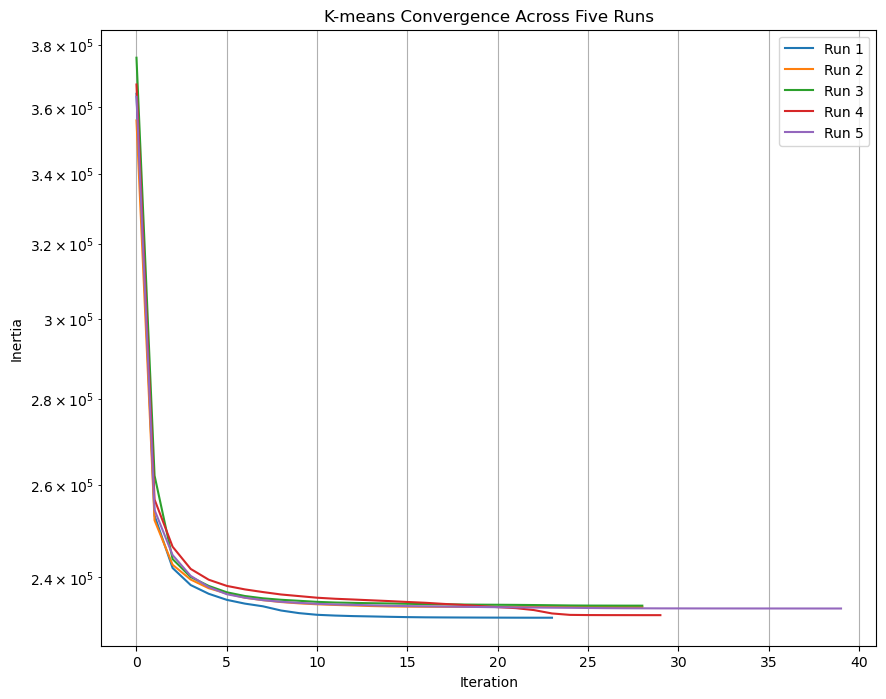

In [53]:
plt.figure(figsize=(10, 8))
for i, inertia_history in enumerate(all_inertia_histories):
    plt.plot(inertia_history, label=f'Run {i+1}')
plt.title('K-means Convergence Across Five Runs')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.legend()
plt.grid(True)
plt.show()


In [55]:
average_nmi = np.mean(all_nmi_scores)
print(f"Average NMI Score over five runs: {average_nmi:.4f}")

Average NMI Score over five runs: 0.3541


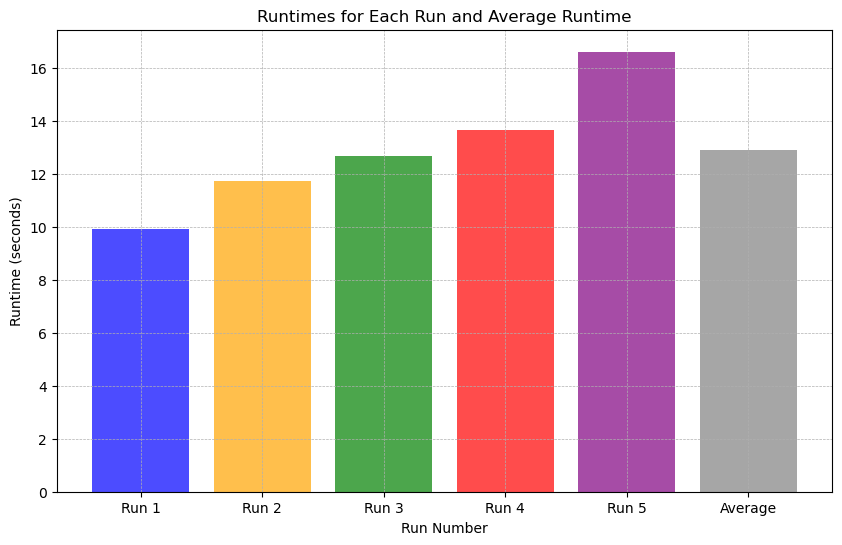

In [54]:
# Assuming `all_runtimes` contains the runtime for each of the five runs
average_runtime = np.mean(all_runtimes)
# Define a list of colors for the bars
colors = ['blue', 'orange', 'green','red',   'purple']

plt.figure(figsize=(10, 6))
bar_colors = colors + ['grey']  # Add grey color for the average bar
plt.bar(range(1, 7), all_runtimes + [average_runtime], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Runtime (seconds)')
plt.title('Runtimes for Each Run and Average Runtime')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



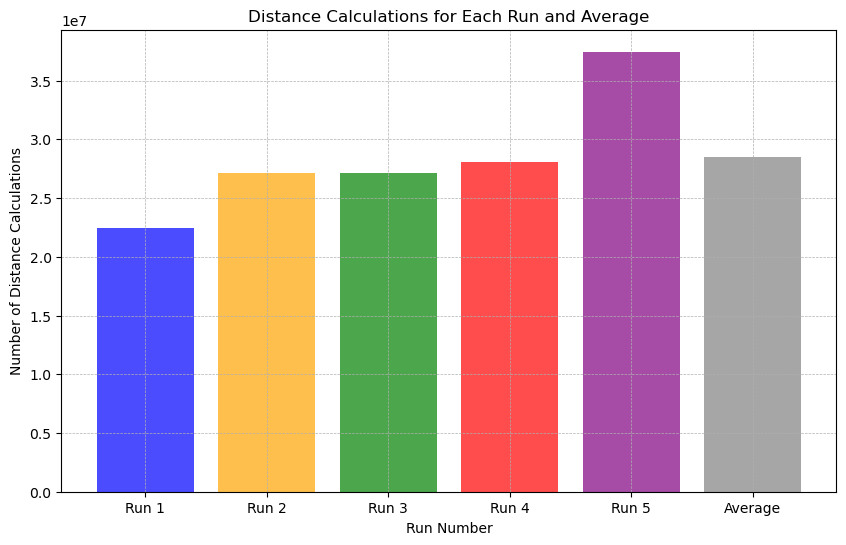

In [56]:
# Assuming `all_distance_calculations` contains the number of distance calculations for each of the five runs
# Distance calculations data and calculation of average
average_distances = np.mean(all_distance_calculations)

# Create a plot for distance calculations with custom colors
plt.figure(figsize=(10, 6))
plt.bar(range(1, 7), all_distance_calculations + [average_distances], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Number of Distance Calculations')
plt.title('Distance Calculations for Each Run and Average')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()